---

# Computational Finance and Financial Management

## Analysis, replication and forecasting of the German TecDAX Stock Index

 By **Merlin Bartel** and **Max Veltwisch**

---

### Introduction

Trying to predict the stock market is an enticing prospect to us, not so much as a desire for material gain, but for the challenge. Already in 1965 the Economist and Nobel Price winner Paul Samuelson postulated in his influencial paper "Properly Anticipated Prices Fluctuate Randomly" that returns of the past have no prediction power for future returns. He concluded that market prices could be considered a Martingale. This in turn implies that the analysis and knowledge about the historical price development of an underlying is of no use for future price predictions. Nevertheless by looking at the daily up and downs of the market, we imagine there must be patterns we can model to beat all odds. Our analysis follows 4 sections:

1. **Exploratory analysis**: Analysing the historical price data of the TecDAX Index over time.
2. **Replication**: Applying a Deep-Learning method to predict the weights of the stocks contained in the TecDAX Index.
3. **Additive Model Forecasting**: Applying the Facebook Prophet model on time-series price data of the TecDAX Index in order to forcast future price movements.
4.  **Recurrent Neural Network Forecasting**: Applying a Long Short-Term Memory (LSTM) model on time-series price data of the TecDAX Index in order to forecast future price movements.

Section 1 serves the goal to better understand the general structure and charateristics of the historical price development of the TecDAX Index. Section 2 differs from the following sections by trying to estimate the weights of the stocks contained in the TecDAX Index in a way that replication becomes as precise as possible. Section 3 and 4 make use of different model approaches with the goal of recognising patterns in the historical price data of the TecDAX Index and using them to forecast future Index prices.


Before we start with our research we load the required python packages into our environment.

In [60]:
#loading required packages
import math
import pylab
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
from datetime import datetime

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.losses import mean_squared_error
from keras import optimizers

import statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import special, optimize

from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

---
## 1. Exploratory Analysis
---
### Data

For this report we are looking at price data of the TecDAX Index from 01.01.2007 - 01.06.2019.  In section 2 we use the price data of all stocks contained in the TexDAX Index from 01.07.2015 - 23.06.2019. The variable of interest in all sections is the adjusted closing price. The following two tables show the structure of both datasets. The source of the datasets is: finance.yahoo.com in combination with onvista.com


In [61]:
# importing TecDAX Index price data
TecDAX = pd.read_csv("TECDAX.csv", index_col=0, parse_dates=True, squeeze=True)

# extracting adjusted close prices (variable of interest)
TecDAX_close = TecDAX["Adj Close"]

# showing the first 5 observations
TecDAX.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-01-02,749.690002,759.510010,749.309998,759.070007,759.070007,126187800
2007-01-03,761.119995,778.429993,761.119995,777.400024,777.400024,0
2007-01-04,772.880005,772.880005,763.270020,765.960022,765.960022,0
2007-01-05,764.059998,765.049988,759.840027,763.309998,763.309998,135319300
2007-01-08,763.150024,767.419983,762.119995,764.450012,764.450012,0


In [62]:
# importing stock data contained in TecDAX Index
TecDAX_stocks = pd.read_csv("YahooAdjCl.csv", encoding='latin-1')
TecDAX_stocks["Date"] = pd.to_datetime(TecDAX_stocks["Date"])

# setting "Date" as index
TecDAX_stocks.set_index("Date", inplace=True)

# showing the first 5 observations
TecDAX_stocks.head()

,TecDAX,1&1 Drillisch,Aixtron,Aumann,Adva,Bechtle,Cancom,Carl Zeiss Meditec,CompuGroup,Dialog Semiconductor,...,SLM,SMA,Software,Stratec,Süss,Telefonica,Telekom,United Internet,Wirecard,Xing
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,1672.390015,35.488747,6.138,0.0,8.830,32.312878,15.390124,23.140257,30.854900,50.439999,...,0.0,19.845375,24.775000,46.892555,0.0,3.897666,0.0,38.481964,35.219498,149.166504
2015-02-07,1658.420044,35.128826,6.186,0.0,8.520,32.572384,15.279471,23.116240,30.434217,49.540001,...,0.0,20.977575,24.750000,46.043972,0.0,3.854635,0.0,37.891987,35.474167,144.268646
2015-03-07,1656.959961,35.119827,6.127,0.0,8.767,32.317509,15.206487,23.250748,30.743683,49.669998,...,0.0,20.438433,24.434999,46.775349,0.0,3.830477,0.0,37.915779,35.773781,143.056290
2015-06-07,1651.089966,34.354984,6.089,0.0,8.765,32.901394,15.133503,23.130648,30.980619,50.200001,...,0.0,20.193369,24.045000,46.039280,0.0,3.769329,0.0,37.663612,35.389278,142.037933
2015-07-07,1625.170044,32.789299,5.983,0.0,8.665,32.794811,16.021078,22.909670,31.498013,48.735001,...,0.0,19.825769,24.230000,46.976948,0.0,3.656845,0.0,37.187820,34.695175,138.206909


### Visualising the data
Visualizing our time-series data enables us to make inferences about important components, such as trend and seasonality and correlation. By plotting the price development of the TecDAX Index over time, we can easily see that the Index has instances of both positive and negative trend, with the later one dominating in the long-run. We also see the price reaction of the Index to the fincial crisis of 2008 and the increasing insecurity at the beginning of 2016. 

We can further compute the daily returns of the prices and verify Paul Samuelsons statement about the unpredictability of stock returns. Just by plotting the daily returns we can already guess that making acurate predictions about future returns will be a hard, if not a outrageous task. Instead of following recurring patterns the returns seem more like white noise fluctuating around a center somewhere at 0. To further confirm this first impression we make use of the autocorrelation function (ACF). This functions helps us understand the correlation component of different returns at different time lags. Lag refers to the time difference between one observation and a previous observation in a dataset. By plotting the ACF we indeed see, that there is almost no statistically significant correlation between todays returns and those in the future. 

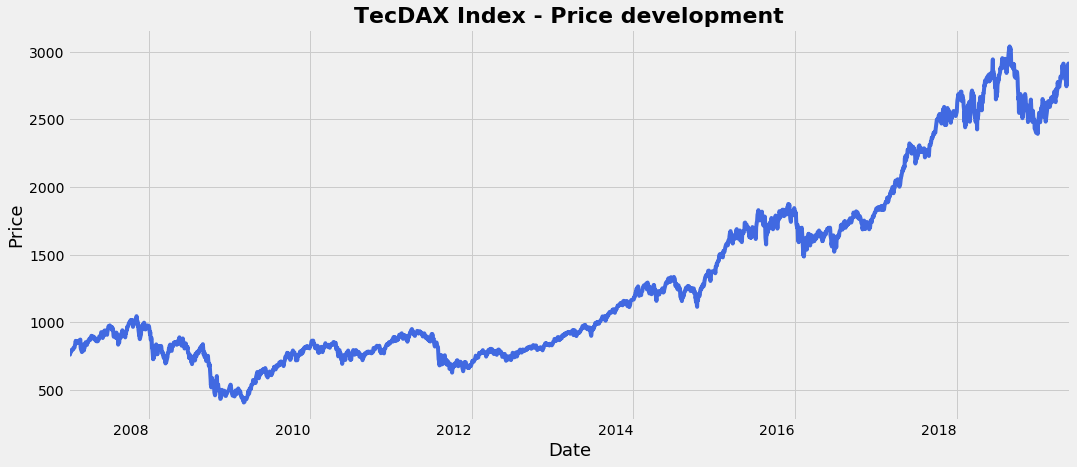

In [63]:
# visualising historical Index price movement
plt.style.use('fivethirtyeight')

TecDAX_close.plot(figsize=(16,8), color="royalblue")
plt.xlabel("Date",fontsize=18,color="black")
plt.ylabel("Price",fontsize=18,color="black")
plt.title("TecDAX Index - Price development",fontweight="bold",fontsize=22)
plt.xticks(rotation=0)

plt.show()

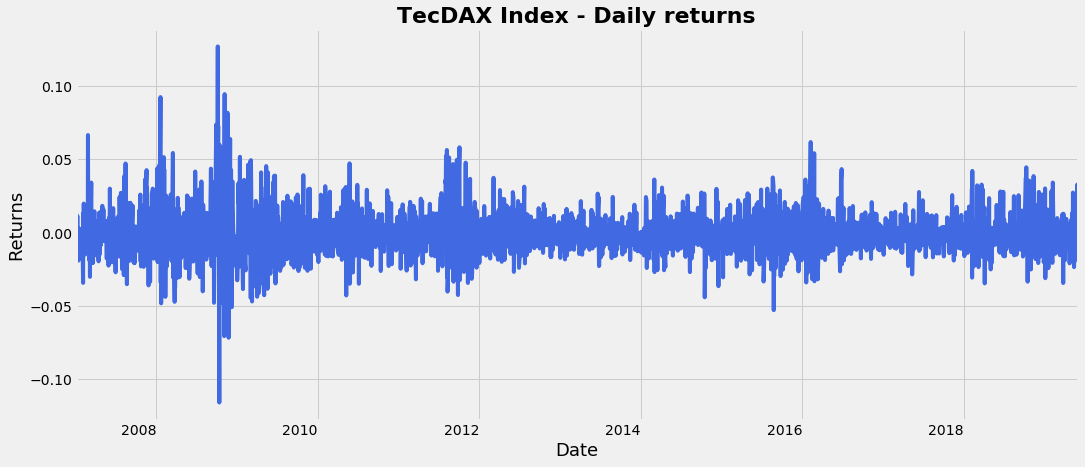

In [64]:
# calculating the daily Index returns
daily_returns = TecDAX_close.shift(1) / TecDAX_close - 1

# visualising the daily Index returns
daily_returns.plot(figsize=(16,8), color="royalblue")
plt.xlabel("Date",fontsize=18,color="black")
plt.ylabel("Returns",fontsize=18,color="black")
plt.title("TecDAX Index - Daily returns", fontweight="bold",fontsize=22)
plt.xticks(rotation=0)

plt.show()

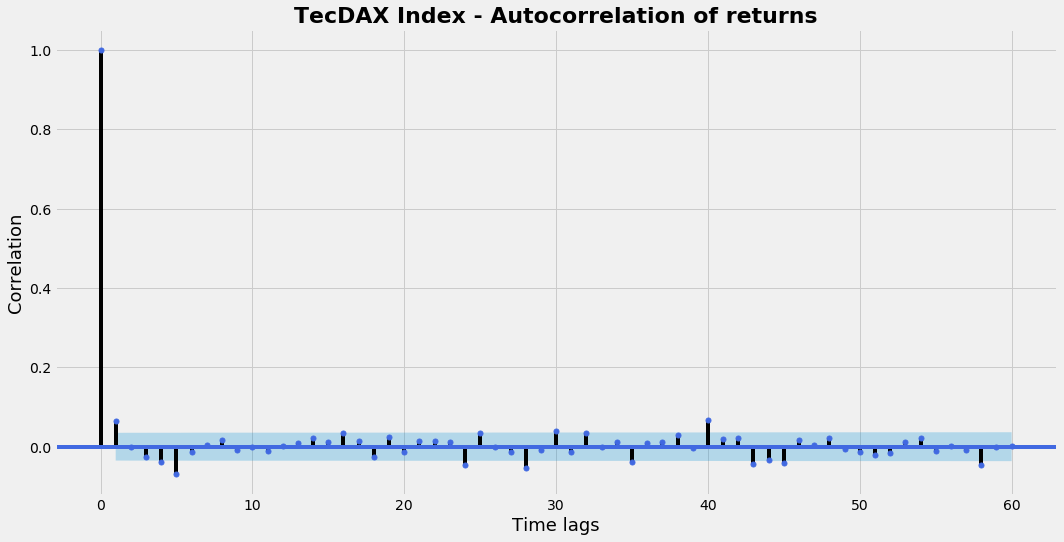

In [65]:
#visualising the autocorrelation of Index returns
plt.rcParams["figure.figsize"] = (16,8)
plot_acf(daily_returns[1:], lags=60, color="royalblue")
plt.title("TecDAX Index - Autocorrelation of returns", fontweight="bold",fontsize=22)
plt.xlabel("Time lags",fontsize=18,color="black")
plt.ylabel("Correlation",fontsize=18,color="black")

plt.show()

---
## 2. Replication 
---

The first model we create is a lean deep neural network, which sets a nice starting point into the world of Deep-Learning. The model is trained on regressing the TecDAX Index on daily historical stock price data.

We use price data of the TecDAX Index reaching from the 01.07.2015 to 23.06.2019 to attain maximum data quality.
As you will see, the optimal lean model does not have Hidden Layers and only one neuron in the Input Layer and is not affected by Overfitting. 
As so, it perfectly shows the minimum criteria for single neurons to be useful. To increase the prediction power of this model, it is indispensable to iterate the model over several weeks and to run tests with different Hyperparameters in order to find the optimal setup. The predictions and metrics of the validationset portraying the missing Overfitting are displayed below.

In [66]:
# importing and indexing stock and index data
TecDAX_stocks = pd.read_csv("YahooAdjCl.csv", encoding='latin-1') 
TecDAX_stocks["Date"] = pd.to_datetime(TecDAX_stocks["Date"])
TecDAX_stocks.set_index("Date", inplace=True)  

# separating TecDAX Index data from stock data
y = TecDAX_stocks["TecDAX"]
y = y.values.reshape(len(y),1)
x = TecDAX_stocks.iloc [0:,1:]
x = x.values.reshape(len(y),41)

# defining prediction horizon
test_size = 27
train_size  = len(y) - test_size

# splitting the data into training and test set
y_train, y_test = y[0:train_size], y[train_size:len(y)]
x_train, x_test = x[0:train_size,:], x[train_size:len(y),:]

# extracting validation set from training set
train_size2  = int(train_size * 0.85)

# creating buffer-variable to combine TecDAX data with underlying stock data
buff = np.append(y_train, x_train, axis =1)

# randomizing sample and splitting TecDAX data from stock data again
np.random.shuffle(buff)
y_buff = buff[:,0]
x_buff = buff[:,1:]
np.reshape(x_buff, (len(x_buff),41))
np.reshape(y_buff, (len(x_buff),1))

# rearranging original Data
y_train, y_valid = y_buff[0:train_size2], y_buff[train_size2:train_size]
x_train, x_valid = x_buff[0:train_size2,:], x_buff[train_size2:train_size,:]

In [67]:
# building the neural network
def index_model():
    model = Sequential()
    
    # input layer
    model.add(Dense(1,activation='linear',input_dim=x_train.shape[1])) #the activation function can be linear, since the network consists of only 1 neuron
    
    # output layer
    model.add(Dense(1)) # Scalar Regression -> No Actication Function
    
    # compiling the model, defining optimizer and loss function
    model.compile(optimizer='Adam',loss='logcosh')
    return model

In [68]:
# !! fitting the model can take significant amount of time and computation power !!

model = index_model()

# traininging the neural network, including validation set to check if overfitting occurs
history = model.fit(x_train, y_train, epochs=10000, validation_data=(x_valid, y_valid))

# getting the performance by using the validaiton set 
Error = model.evaluate(x_train, y_train)
print("Error for the test set: ", Error)

Train on 832 samples, validate on 147 samples
Epoch 1/10000
832/832 [==============================] - 1s 2ms/step - loss: 2170.4810 - val_loss: 2215.2774
Epoch 2/10000
832/832 [==============================] - 0s 52us/step - loss: 2162.2371 - val_loss: 2205.0754
Epoch 3/10000
832/832 [==============================] - 0s 55us/step - loss: 2150.8264 - val_loss: 2191.1968
Epoch 4/10000
832/832 [==============================] - 0s 53us/step - loss: 2135.5610 - val_loss: 2173.2718
Epoch 5/10000
832/832 [==============================] - 0s 53us/step - loss: 2116.2053 - val_loss: 2150.8255
Epoch 6/10000
832/832 [==============================] - 0s 53us/step - loss: 2092.3545 - val_loss: 2123.7952
Epoch 7/10000
832/832 [==============================] - 0s 55us/step - loss: 2063.9532 - val_loss: 2091.9096
Epoch 8/10000
832/832 [==============================] - 0s 55us/step - loss: 2030.7254 - val_loss: 2055.2979
Epoch 9/10000
832/832 [==============================] - 0s 54us/step - los

832/832 [==============================] - 0s 48us/step - loss: 19.0049 - val_loss: 22.4975
Epoch 153/10000
832/832 [==============================] - 0s 50us/step - loss: 18.9449 - val_loss: 22.4842
Epoch 154/10000
832/832 [==============================] - 0s 46us/step - loss: 18.7798 - val_loss: 23.2236
Epoch 155/10000
832/832 [==============================] - 0s 47us/step - loss: 19.0992 - val_loss: 22.3963
Epoch 156/10000
832/832 [==============================] - 0s 48us/step - loss: 18.7970 - val_loss: 22.1397
Epoch 157/10000
832/832 [==============================] - 0s 47us/step - loss: 18.6001 - val_loss: 22.1356
Epoch 158/10000
832/832 [==============================] - 0s 48us/step - loss: 18.6539 - val_loss: 22.0988
Epoch 159/10000
832/832 [==============================] - 0s 48us/step - loss: 18.6221 - val_loss: 21.9258
Epoch 160/10000
832/832 [==============================] - 0s 47us/step - loss: 18.5780 - val_loss: 21.9338
Epoch 161/10000
832/832 [===================

832/832 [==============================] - 0s 48us/step - loss: 15.8021 - val_loss: 18.4791
Epoch 229/10000
832/832 [==============================] - 0s 54us/step - loss: 16.0692 - val_loss: 18.3895
Epoch 230/10000
832/832 [==============================] - 0s 47us/step - loss: 16.0720 - val_loss: 18.6085
Epoch 231/10000
832/832 [==============================] - 0s 48us/step - loss: 15.6947 - val_loss: 18.4081
Epoch 232/10000
832/832 [==============================] - 0s 47us/step - loss: 15.7446 - val_loss: 18.4526
Epoch 233/10000
832/832 [==============================] - 0s 47us/step - loss: 15.6278 - val_loss: 17.9438
Epoch 234/10000
832/832 [==============================] - 0s 48us/step - loss: 15.4776 - val_loss: 17.9716
Epoch 235/10000
832/832 [==============================] - 0s 47us/step - loss: 15.3948 - val_loss: 17.9121
Epoch 236/10000
832/832 [==============================] - 0s 48us/step - loss: 15.4999 - val_loss: 17.8509
Epoch 237/10000
832/832 [===================

832/832 [==============================] - 0s 48us/step - loss: 13.6393 - val_loss: 16.1704
Epoch 305/10000
832/832 [==============================] - 0s 48us/step - loss: 13.6649 - val_loss: 16.2039
Epoch 306/10000
832/832 [==============================] - 0s 47us/step - loss: 13.8186 - val_loss: 15.7591
Epoch 307/10000
832/832 [==============================] - 0s 47us/step - loss: 13.6034 - val_loss: 15.6375
Epoch 308/10000
832/832 [==============================] - 0s 45us/step - loss: 13.6026 - val_loss: 15.6779
Epoch 309/10000
832/832 [==============================] - 0s 48us/step - loss: 13.6534 - val_loss: 16.1205
Epoch 310/10000
832/832 [==============================] - 0s 47us/step - loss: 13.5116 - val_loss: 15.6400
Epoch 311/10000
832/832 [==============================] - 0s 48us/step - loss: 13.4991 - val_loss: 15.5359
Epoch 312/10000
832/832 [==============================] - 0s 48us/step - loss: 13.4721 - val_loss: 15.5184
Epoch 313/10000
832/832 [===================

832/832 [==============================] - 0s 49us/step - loss: 12.1780 - val_loss: 14.0773
Epoch 381/10000
832/832 [==============================] - 0s 48us/step - loss: 12.2651 - val_loss: 14.1251
Epoch 382/10000
832/832 [==============================] - 0s 47us/step - loss: 12.2203 - val_loss: 14.0006
Epoch 383/10000
832/832 [==============================] - 0s 47us/step - loss: 12.1648 - val_loss: 13.9605
Epoch 384/10000
832/832 [==============================] - 0s 47us/step - loss: 12.3005 - val_loss: 13.9407
Epoch 385/10000
832/832 [==============================] - 0s 48us/step - loss: 12.2117 - val_loss: 13.9761
Epoch 386/10000
832/832 [==============================] - 0s 47us/step - loss: 12.0980 - val_loss: 13.7946
Epoch 387/10000
832/832 [==============================] - 0s 48us/step - loss: 12.0428 - val_loss: 14.3093
Epoch 388/10000
832/832 [==============================] - 0s 46us/step - loss: 12.1751 - val_loss: 13.7484
Epoch 389/10000
832/832 [===================

832/832 [==============================] - 0s 47us/step - loss: 11.6220 - val_loss: 12.6561
Epoch 457/10000
832/832 [==============================] - 0s 48us/step - loss: 11.1603 - val_loss: 12.5737
Epoch 458/10000
832/832 [==============================] - 0s 47us/step - loss: 11.0821 - val_loss: 12.5205
Epoch 459/10000
832/832 [==============================] - 0s 47us/step - loss: 11.1395 - val_loss: 12.4086
Epoch 460/10000
832/832 [==============================] - 0s 47us/step - loss: 11.1891 - val_loss: 12.5496
Epoch 461/10000
832/832 [==============================] - 0s 47us/step - loss: 11.0865 - val_loss: 12.6044
Epoch 462/10000
832/832 [==============================] - 0s 48us/step - loss: 11.1695 - val_loss: 12.4942
Epoch 463/10000
832/832 [==============================] - 0s 47us/step - loss: 10.9761 - val_loss: 12.3624
Epoch 464/10000
832/832 [==============================] - 0s 48us/step - loss: 11.0127 - val_loss: 12.4599
Epoch 465/10000
832/832 [===================

832/832 [==============================] - 0s 48us/step - loss: 10.2366 - val_loss: 11.4058
Epoch 533/10000
832/832 [==============================] - 0s 48us/step - loss: 10.2498 - val_loss: 11.5159
Epoch 534/10000
832/832 [==============================] - 0s 48us/step - loss: 10.3526 - val_loss: 11.3931
Epoch 535/10000
832/832 [==============================] - 0s 47us/step - loss: 10.3526 - val_loss: 12.1290
Epoch 536/10000
832/832 [==============================] - 0s 47us/step - loss: 10.5787 - val_loss: 11.4787
Epoch 537/10000
832/832 [==============================] - 0s 48us/step - loss: 10.1845 - val_loss: 11.4637
Epoch 538/10000
832/832 [==============================] - 0s 47us/step - loss: 10.2321 - val_loss: 11.3478
Epoch 539/10000
832/832 [==============================] - 0s 47us/step - loss: 10.2047 - val_loss: 11.3445
Epoch 540/10000
832/832 [==============================] - 0s 47us/step - loss: 10.1582 - val_loss: 11.4508
Epoch 541/10000
832/832 [===================

Epoch 685/10000
832/832 [==============================] - 0s 49us/step - loss: 8.9027 - val_loss: 10.1669
Epoch 686/10000
832/832 [==============================] - 0s 48us/step - loss: 8.9758 - val_loss: 9.8254
Epoch 687/10000
832/832 [==============================] - 0s 47us/step - loss: 8.9211 - val_loss: 9.8067
Epoch 688/10000
832/832 [==============================] - 0s 47us/step - loss: 9.0764 - val_loss: 9.8083
Epoch 689/10000
832/832 [==============================] - 0s 48us/step - loss: 8.9050 - val_loss: 9.8661
Epoch 690/10000
832/832 [==============================] - 0s 47us/step - loss: 8.9270 - val_loss: 9.8311
Epoch 691/10000
832/832 [==============================] - 0s 45us/step - loss: 9.1790 - val_loss: 9.7704
Epoch 692/10000
832/832 [==============================] - 0s 48us/step - loss: 9.1115 - val_loss: 9.8369
Epoch 693/10000
832/832 [==============================] - 0s 47us/step - loss: 8.9073 - val_loss: 9.9660
Epoch 694/10000
832/832 [====================

832/832 [==============================] - 0s 48us/step - loss: 8.0371 - val_loss: 8.6825
Epoch 840/10000
832/832 [==============================] - 0s 49us/step - loss: 8.0433 - val_loss: 8.6993
Epoch 841/10000
832/832 [==============================] - 0s 49us/step - loss: 8.0853 - val_loss: 8.6688
Epoch 842/10000
832/832 [==============================] - 0s 48us/step - loss: 8.1294 - val_loss: 8.6614
Epoch 843/10000
832/832 [==============================] - 0s 48us/step - loss: 8.0694 - val_loss: 8.6432
Epoch 844/10000
832/832 [==============================] - 0s 49us/step - loss: 8.1087 - val_loss: 9.0732
Epoch 845/10000
832/832 [==============================] - 0s 48us/step - loss: 8.0326 - val_loss: 8.6218
Epoch 846/10000
832/832 [==============================] - 0s 48us/step - loss: 8.0741 - val_loss: 8.6291
Epoch 847/10000
832/832 [==============================] - 0s 47us/step - loss: 8.0381 - val_loss: 8.6122
Epoch 848/10000
832/832 [==============================] - 0s 

832/832 [==============================] - 0s 48us/step - loss: 7.3831 - val_loss: 7.9476
Epoch 994/10000
832/832 [==============================] - 0s 50us/step - loss: 7.3233 - val_loss: 8.1816
Epoch 995/10000
832/832 [==============================] - 0s 46us/step - loss: 7.3997 - val_loss: 7.8315
Epoch 996/10000
832/832 [==============================] - 0s 47us/step - loss: 7.4261 - val_loss: 7.9869
Epoch 997/10000
832/832 [==============================] - 0s 48us/step - loss: 7.4965 - val_loss: 7.8182
Epoch 998/10000
832/832 [==============================] - 0s 46us/step - loss: 7.3683 - val_loss: 7.8991
Epoch 999/10000
832/832 [==============================] - 0s 47us/step - loss: 7.4741 - val_loss: 7.9014
Epoch 1000/10000
832/832 [==============================] - 0s 47us/step - loss: 7.6109 - val_loss: 8.0697
Epoch 1001/10000
832/832 [==============================] - 0s 47us/step - loss: 7.4605 - val_loss: 7.8471
Epoch 1002/10000
832/832 [==============================] - 

Epoch 1070/10000
832/832 [==============================] - 0s 50us/step - loss: 7.1083 - val_loss: 7.7262
Epoch 1071/10000
832/832 [==============================] - 0s 48us/step - loss: 7.2732 - val_loss: 7.6169
Epoch 1072/10000
832/832 [==============================] - 0s 47us/step - loss: 7.2165 - val_loss: 8.3748
Epoch 1073/10000
832/832 [==============================] - 0s 46us/step - loss: 7.5690 - val_loss: 7.8424
Epoch 1074/10000
832/832 [==============================] - 0s 47us/step - loss: 7.0614 - val_loss: 7.5437
Epoch 1075/10000
832/832 [==============================] - 0s 48us/step - loss: 7.1931 - val_loss: 7.5444
Epoch 1076/10000
832/832 [==============================] - 0s 48us/step - loss: 7.1024 - val_loss: 7.5045
Epoch 1077/10000
832/832 [==============================] - 0s 49us/step - loss: 7.0932 - val_loss: 7.4815
Epoch 1078/10000
832/832 [==============================] - 0s 47us/step - loss: 7.3083 - val_loss: 7.4952
Epoch 1079/10000
832/832 [===========

832/832 [==============================] - 0s 50us/step - loss: 6.6656 - val_loss: 7.1549
Epoch 1223/10000
832/832 [==============================] - 0s 49us/step - loss: 6.8144 - val_loss: 7.0423
Epoch 1224/10000
832/832 [==============================] - 0s 47us/step - loss: 6.6852 - val_loss: 7.0355
Epoch 1225/10000
832/832 [==============================] - 0s 47us/step - loss: 6.7898 - val_loss: 7.1393
Epoch 1226/10000
832/832 [==============================] - 0s 47us/step - loss: 6.6703 - val_loss: 7.0121
Epoch 1227/10000
832/832 [==============================] - 0s 47us/step - loss: 6.6930 - val_loss: 6.9889
Epoch 1228/10000
832/832 [==============================] - 0s 46us/step - loss: 6.7353 - val_loss: 7.1339
Epoch 1229/10000
832/832 [==============================] - 0s 48us/step - loss: 6.7107 - val_loss: 7.1061
Epoch 1230/10000
832/832 [==============================] - 0s 47us/step - loss: 6.8232 - val_loss: 7.0617
Epoch 1231/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 6.3442 - val_loss: 6.8047
Epoch 1375/10000
832/832 [==============================] - 0s 49us/step - loss: 6.3302 - val_loss: 6.7132
Epoch 1376/10000
832/832 [==============================] - 0s 47us/step - loss: 6.4666 - val_loss: 6.7131
Epoch 1377/10000
832/832 [==============================] - 0s 46us/step - loss: 6.4469 - val_loss: 6.8445
Epoch 1378/10000
832/832 [==============================] - 0s 47us/step - loss: 6.3674 - val_loss: 6.6595
Epoch 1379/10000
832/832 [==============================] - 0s 46us/step - loss: 6.3210 - val_loss: 7.0136
Epoch 1380/10000
832/832 [==============================] - 0s 47us/step - loss: 6.4474 - val_loss: 6.7091
Epoch 1381/10000
832/832 [==============================] - 0s 48us/step - loss: 6.3311 - val_loss: 6.9244
Epoch 1382/10000
832/832 [==============================] - 0s 47us/step - loss: 6.2929 - val_loss: 6.7275
Epoch 1383/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 6.1682 - val_loss: 6.6078
Epoch 1527/10000
832/832 [==============================] - 0s 48us/step - loss: 6.1011 - val_loss: 6.4028
Epoch 1528/10000
832/832 [==============================] - 0s 48us/step - loss: 6.1936 - val_loss: 6.7840
Epoch 1529/10000
832/832 [==============================] - 0s 46us/step - loss: 6.3329 - val_loss: 6.7752
Epoch 1530/10000
832/832 [==============================] - 0s 46us/step - loss: 6.0933 - val_loss: 6.5081
Epoch 1531/10000
832/832 [==============================] - 0s 48us/step - loss: 6.0450 - val_loss: 6.4048
Epoch 1532/10000
832/832 [==============================] - 0s 46us/step - loss: 6.0329 - val_loss: 6.4597
Epoch 1533/10000
832/832 [==============================] - 0s 48us/step - loss: 6.0162 - val_loss: 6.4079
Epoch 1534/10000
832/832 [==============================] - 0s 46us/step - loss: 6.1161 - val_loss: 6.6613
Epoch 1535/10000
832/832 [============================

832/832 [==============================] - 0s 46us/step - loss: 5.8300 - val_loss: 6.2801
Epoch 1679/10000
832/832 [==============================] - 0s 49us/step - loss: 5.8413 - val_loss: 6.3429
Epoch 1680/10000
832/832 [==============================] - 0s 47us/step - loss: 5.8139 - val_loss: 6.2295
Epoch 1681/10000
832/832 [==============================] - 0s 46us/step - loss: 5.8961 - val_loss: 6.4760
Epoch 1682/10000
832/832 [==============================] - 0s 45us/step - loss: 5.9262 - val_loss: 6.3702
Epoch 1683/10000
832/832 [==============================] - 0s 48us/step - loss: 5.8423 - val_loss: 6.3433
Epoch 1684/10000
832/832 [==============================] - 0s 48us/step - loss: 5.8348 - val_loss: 6.3316
Epoch 1685/10000
832/832 [==============================] - 0s 48us/step - loss: 5.8076 - val_loss: 6.4104
Epoch 1686/10000
832/832 [==============================] - 0s 46us/step - loss: 5.8229 - val_loss: 6.2944
Epoch 1687/10000
832/832 [============================

832/832 [==============================] - 0s 46us/step - loss: 5.7240 - val_loss: 6.1866
Epoch 1831/10000
832/832 [==============================] - 0s 49us/step - loss: 5.7191 - val_loss: 6.2704
Epoch 1832/10000
832/832 [==============================] - 0s 48us/step - loss: 5.6821 - val_loss: 6.1380
Epoch 1833/10000
832/832 [==============================] - 0s 47us/step - loss: 5.7555 - val_loss: 6.4887
Epoch 1834/10000
832/832 [==============================] - 0s 45us/step - loss: 5.8941 - val_loss: 6.4347
Epoch 1835/10000
832/832 [==============================] - 0s 46us/step - loss: 5.8160 - val_loss: 6.8709
Epoch 1836/10000
832/832 [==============================] - 0s 50us/step - loss: 5.8260 - val_loss: 6.1721
Epoch 1837/10000
832/832 [==============================] - 0s 46us/step - loss: 5.5837 - val_loss: 6.1803
Epoch 1838/10000
832/832 [==============================] - 0s 48us/step - loss: 5.6240 - val_loss: 6.1438
Epoch 1839/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 5.4167 - val_loss: 6.2747
Epoch 1983/10000
832/832 [==============================] - 0s 47us/step - loss: 5.5597 - val_loss: 6.2209
Epoch 1984/10000
832/832 [==============================] - 0s 48us/step - loss: 5.4679 - val_loss: 6.0587
Epoch 1985/10000
832/832 [==============================] - 0s 46us/step - loss: 5.4375 - val_loss: 6.0707
Epoch 1986/10000
832/832 [==============================] - 0s 50us/step - loss: 5.4467 - val_loss: 6.1771
Epoch 1987/10000
832/832 [==============================] - 0s 45us/step - loss: 5.4464 - val_loss: 6.0541
Epoch 1988/10000
832/832 [==============================] - 0s 45us/step - loss: 5.4928 - val_loss: 6.3502
Epoch 1989/10000
832/832 [==============================] - 0s 51us/step - loss: 5.5843 - val_loss: 6.1022
Epoch 1990/10000
832/832 [==============================] - 0s 48us/step - loss: 5.4559 - val_loss: 6.1101
Epoch 1991/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 5.3123 - val_loss: 6.1090
Epoch 2135/10000
832/832 [==============================] - 0s 49us/step - loss: 5.2760 - val_loss: 5.9839
Epoch 2136/10000
832/832 [==============================] - 0s 47us/step - loss: 5.3435 - val_loss: 6.1503
Epoch 2137/10000
832/832 [==============================] - 0s 47us/step - loss: 5.4066 - val_loss: 5.9608
Epoch 2138/10000
832/832 [==============================] - 0s 49us/step - loss: 5.3163 - val_loss: 5.9020
Epoch 2139/10000
832/832 [==============================] - 0s 46us/step - loss: 5.3148 - val_loss: 6.1870
Epoch 2140/10000
832/832 [==============================] - 0s 46us/step - loss: 5.2590 - val_loss: 6.0373
Epoch 2141/10000
832/832 [==============================] - 0s 47us/step - loss: 5.2391 - val_loss: 6.1904
Epoch 2142/10000
832/832 [==============================] - 0s 47us/step - loss: 5.3093 - val_loss: 5.9082
Epoch 2143/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 5.2372 - val_loss: 5.9803
Epoch 2287/10000
832/832 [==============================] - 0s 48us/step - loss: 5.2188 - val_loss: 5.9723
Epoch 2288/10000
832/832 [==============================] - 0s 48us/step - loss: 5.1650 - val_loss: 5.8772
Epoch 2289/10000
832/832 [==============================] - 0s 48us/step - loss: 5.1192 - val_loss: 5.8801
Epoch 2290/10000
832/832 [==============================] - 0s 48us/step - loss: 5.2205 - val_loss: 5.8556
Epoch 2291/10000
832/832 [==============================] - 0s 49us/step - loss: 5.0995 - val_loss: 6.2781
Epoch 2292/10000
832/832 [==============================] - 0s 47us/step - loss: 5.2035 - val_loss: 6.2063
Epoch 2293/10000
832/832 [==============================] - 0s 46us/step - loss: 5.2170 - val_loss: 5.9143
Epoch 2294/10000
832/832 [==============================] - 0s 47us/step - loss: 5.1434 - val_loss: 5.9762
Epoch 2295/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.9599 - val_loss: 5.8439
Epoch 2439/10000
832/832 [==============================] - 0s 46us/step - loss: 5.1218 - val_loss: 5.8323
Epoch 2440/10000
832/832 [==============================] - 0s 48us/step - loss: 5.1054 - val_loss: 5.7561
Epoch 2441/10000
832/832 [==============================] - 0s 47us/step - loss: 5.0774 - val_loss: 5.7938
Epoch 2442/10000
832/832 [==============================] - 0s 47us/step - loss: 5.0168 - val_loss: 5.8302
Epoch 2443/10000
832/832 [==============================] - 0s 47us/step - loss: 4.9855 - val_loss: 5.7992
Epoch 2444/10000
832/832 [==============================] - 0s 48us/step - loss: 5.0323 - val_loss: 5.8033
Epoch 2445/10000
832/832 [==============================] - 0s 48us/step - loss: 5.0707 - val_loss: 5.7799
Epoch 2446/10000
832/832 [==============================] - 0s 46us/step - loss: 4.9694 - val_loss: 5.7608
Epoch 2447/10000
832/832 [============================

832/832 [==============================] - 0s 46us/step - loss: 4.8856 - val_loss: 5.7083
Epoch 2591/10000
832/832 [==============================] - 0s 48us/step - loss: 4.8412 - val_loss: 5.6641
Epoch 2592/10000
832/832 [==============================] - 0s 48us/step - loss: 4.9195 - val_loss: 5.6748
Epoch 2593/10000
832/832 [==============================] - 0s 48us/step - loss: 4.9765 - val_loss: 5.8119
Epoch 2594/10000
832/832 [==============================] - 0s 47us/step - loss: 4.9169 - val_loss: 5.8494
Epoch 2595/10000
832/832 [==============================] - 0s 47us/step - loss: 4.8713 - val_loss: 5.7133
Epoch 2596/10000
832/832 [==============================] - 0s 46us/step - loss: 4.9407 - val_loss: 5.6994
Epoch 2597/10000
832/832 [==============================] - 0s 48us/step - loss: 4.8791 - val_loss: 5.6670
Epoch 2598/10000
832/832 [==============================] - 0s 50us/step - loss: 4.8871 - val_loss: 5.6739
Epoch 2599/10000
832/832 [============================

832/832 [==============================] - 0s 46us/step - loss: 4.8385 - val_loss: 5.7877
Epoch 2743/10000
832/832 [==============================] - 0s 47us/step - loss: 4.8575 - val_loss: 5.6916
Epoch 2744/10000
832/832 [==============================] - 0s 46us/step - loss: 4.7894 - val_loss: 5.7112
Epoch 2745/10000
832/832 [==============================] - 0s 49us/step - loss: 4.7579 - val_loss: 5.7472
Epoch 2746/10000
832/832 [==============================] - 0s 47us/step - loss: 4.8276 - val_loss: 5.6854
Epoch 2747/10000
832/832 [==============================] - 0s 47us/step - loss: 4.8884 - val_loss: 5.9001
Epoch 2748/10000
832/832 [==============================] - 0s 47us/step - loss: 4.7476 - val_loss: 5.7015
Epoch 2749/10000
832/832 [==============================] - 0s 46us/step - loss: 4.9757 - val_loss: 5.6653
Epoch 2750/10000
832/832 [==============================] - 0s 47us/step - loss: 4.9103 - val_loss: 5.7102
Epoch 2751/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 4.7140 - val_loss: 5.6269
Epoch 2895/10000
832/832 [==============================] - 0s 49us/step - loss: 4.8170 - val_loss: 5.6195
Epoch 2896/10000
832/832 [==============================] - 0s 48us/step - loss: 4.6793 - val_loss: 5.6144
Epoch 2897/10000
832/832 [==============================] - 0s 46us/step - loss: 4.7103 - val_loss: 5.5766
Epoch 2898/10000
832/832 [==============================] - 0s 47us/step - loss: 4.6600 - val_loss: 5.6606
Epoch 2899/10000
832/832 [==============================] - 0s 46us/step - loss: 4.7340 - val_loss: 5.6787
Epoch 2900/10000
832/832 [==============================] - 0s 46us/step - loss: 4.6960 - val_loss: 5.6313
Epoch 2901/10000
832/832 [==============================] - 0s 47us/step - loss: 4.6990 - val_loss: 6.1678
Epoch 2902/10000
832/832 [==============================] - 0s 47us/step - loss: 4.9460 - val_loss: 5.7137
Epoch 2903/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.6394 - val_loss: 5.6048
Epoch 3047/10000
832/832 [==============================] - 0s 49us/step - loss: 4.7019 - val_loss: 6.2226
Epoch 3048/10000
832/832 [==============================] - 0s 47us/step - loss: 4.7330 - val_loss: 5.6906
Epoch 3049/10000
832/832 [==============================] - 0s 48us/step - loss: 4.6823 - val_loss: 6.0195
Epoch 3050/10000
832/832 [==============================] - 0s 48us/step - loss: 4.7755 - val_loss: 5.5801
Epoch 3051/10000
832/832 [==============================] - 0s 48us/step - loss: 4.6126 - val_loss: 5.6363
Epoch 3052/10000
832/832 [==============================] - 0s 47us/step - loss: 4.5987 - val_loss: 5.6892
Epoch 3053/10000
832/832 [==============================] - 0s 46us/step - loss: 4.6303 - val_loss: 5.6615
Epoch 3054/10000
832/832 [==============================] - 0s 47us/step - loss: 4.7509 - val_loss: 5.6870
Epoch 3055/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.6562 - val_loss: 5.5458
Epoch 3199/10000
832/832 [==============================] - 0s 48us/step - loss: 4.5444 - val_loss: 5.5578
Epoch 3200/10000
832/832 [==============================] - 0s 48us/step - loss: 4.6105 - val_loss: 5.5741
Epoch 3201/10000
832/832 [==============================] - 0s 47us/step - loss: 4.6703 - val_loss: 5.5263
Epoch 3202/10000
832/832 [==============================] - 0s 48us/step - loss: 4.5862 - val_loss: 5.6261
Epoch 3203/10000
832/832 [==============================] - 0s 47us/step - loss: 4.5814 - val_loss: 5.7578
Epoch 3204/10000
832/832 [==============================] - 0s 46us/step - loss: 4.5908 - val_loss: 5.8365
Epoch 3205/10000
832/832 [==============================] - 0s 47us/step - loss: 4.6950 - val_loss: 5.6964
Epoch 3206/10000
832/832 [==============================] - 0s 47us/step - loss: 4.7483 - val_loss: 5.6467
Epoch 3207/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 4.4810 - val_loss: 5.6144
Epoch 3351/10000
832/832 [==============================] - 0s 48us/step - loss: 4.5081 - val_loss: 5.5108
Epoch 3352/10000
832/832 [==============================] - 0s 47us/step - loss: 4.5631 - val_loss: 5.6845
Epoch 3353/10000
832/832 [==============================] - 0s 47us/step - loss: 4.5947 - val_loss: 5.5829
Epoch 3354/10000
832/832 [==============================] - 0s 46us/step - loss: 4.4367 - val_loss: 5.5608
Epoch 3355/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4810 - val_loss: 5.5838
Epoch 3356/10000
832/832 [==============================] - 0s 48us/step - loss: 4.4660 - val_loss: 5.6596
Epoch 3357/10000
832/832 [==============================] - 0s 48us/step - loss: 4.4685 - val_loss: 5.6177
Epoch 3358/10000
832/832 [==============================] - 0s 46us/step - loss: 4.5145 - val_loss: 5.7975
Epoch 3359/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.4210 - val_loss: 5.4744
Epoch 3503/10000
832/832 [==============================] - 0s 50us/step - loss: 4.4390 - val_loss: 5.5252
Epoch 3504/10000
832/832 [==============================] - 0s 49us/step - loss: 4.4653 - val_loss: 5.4962
Epoch 3505/10000
832/832 [==============================] - 0s 48us/step - loss: 4.4852 - val_loss: 5.6817
Epoch 3506/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4616 - val_loss: 5.6303
Epoch 3507/10000
832/832 [==============================] - 0s 46us/step - loss: 4.4916 - val_loss: 5.6075
Epoch 3508/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4768 - val_loss: 5.9058
Epoch 3509/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4187 - val_loss: 6.0894
Epoch 3510/10000
832/832 [==============================] - 0s 47us/step - loss: 4.6191 - val_loss: 5.6618
Epoch 3511/10000
832/832 [============================

832/832 [==============================] - 0s 46us/step - loss: 4.3542 - val_loss: 5.7800
Epoch 3655/10000
832/832 [==============================] - 0s 49us/step - loss: 4.4156 - val_loss: 5.5773
Epoch 3656/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4323 - val_loss: 6.0247
Epoch 3657/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4935 - val_loss: 5.5330
Epoch 3658/10000
832/832 [==============================] - 0s 48us/step - loss: 4.5052 - val_loss: 5.7005
Epoch 3659/10000
832/832 [==============================] - 0s 46us/step - loss: 4.4806 - val_loss: 5.6574
Epoch 3660/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3833 - val_loss: 5.4636
Epoch 3661/10000
832/832 [==============================] - 0s 47us/step - loss: 4.5828 - val_loss: 5.6862
Epoch 3662/10000
832/832 [==============================] - 0s 47us/step - loss: 4.3999 - val_loss: 5.9824
Epoch 3663/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 4.3720 - val_loss: 5.5560
Epoch 3807/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3808 - val_loss: 5.5118
Epoch 3808/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3710 - val_loss: 5.6296
Epoch 3809/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4553 - val_loss: 5.6501
Epoch 3810/10000
832/832 [==============================] - 0s 46us/step - loss: 4.4000 - val_loss: 5.8273
Epoch 3811/10000
832/832 [==============================] - 0s 47us/step - loss: 4.3489 - val_loss: 5.5002
Epoch 3812/10000
832/832 [==============================] - 0s 48us/step - loss: 4.4077 - val_loss: 5.4679
Epoch 3813/10000
832/832 [==============================] - 0s 49us/step - loss: 4.4104 - val_loss: 5.4862
Epoch 3814/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4791 - val_loss: 5.6510
Epoch 3815/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 4.2928 - val_loss: 5.4311
Epoch 3959/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3759 - val_loss: 5.4038
Epoch 3960/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3755 - val_loss: 5.3836
Epoch 3961/10000
832/832 [==============================] - 0s 47us/step - loss: 4.3412 - val_loss: 5.5136
Epoch 3962/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2959 - val_loss: 5.4001
Epoch 3963/10000
832/832 [==============================] - 0s 47us/step - loss: 4.3480 - val_loss: 5.5199
Epoch 3964/10000
832/832 [==============================] - 0s 47us/step - loss: 4.3203 - val_loss: 5.4326
Epoch 3965/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3969 - val_loss: 5.4553
Epoch 3966/10000
832/832 [==============================] - 0s 47us/step - loss: 4.4781 - val_loss: 5.6049
Epoch 3967/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.3120 - val_loss: 5.6605
Epoch 4111/10000
832/832 [==============================] - 0s 48us/step - loss: 4.4974 - val_loss: 5.8581
Epoch 4112/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3839 - val_loss: 5.4318
Epoch 4113/10000
832/832 [==============================] - 0s 47us/step - loss: 4.3023 - val_loss: 5.4040
Epoch 4114/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2662 - val_loss: 5.3972
Epoch 4115/10000
832/832 [==============================] - 0s 49us/step - loss: 4.2684 - val_loss: 5.6274
Epoch 4116/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3626 - val_loss: 5.4026
Epoch 4117/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3066 - val_loss: 5.3944
Epoch 4118/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3313 - val_loss: 5.3857
Epoch 4119/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 4.3136 - val_loss: 5.3973
Epoch 4263/10000
832/832 [==============================] - 0s 51us/step - loss: 4.3657 - val_loss: 5.3789
Epoch 4264/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2808 - val_loss: 5.3777
Epoch 4265/10000
832/832 [==============================] - 0s 49us/step - loss: 4.2715 - val_loss: 5.3807
Epoch 4266/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2215 - val_loss: 5.5833
Epoch 4267/10000
832/832 [==============================] - 0s 48us/step - loss: 4.3634 - val_loss: 5.3908
Epoch 4268/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2578 - val_loss: 5.5160
Epoch 4269/10000
832/832 [==============================] - 0s 45us/step - loss: 4.2943 - val_loss: 5.4077
Epoch 4270/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2637 - val_loss: 5.4229
Epoch 4271/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 4.3002 - val_loss: 5.5247
Epoch 4415/10000
832/832 [==============================] - 0s 47us/step - loss: 4.6732 - val_loss: 5.3423
Epoch 4416/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2126 - val_loss: 5.4385
Epoch 4417/10000
832/832 [==============================] - 0s 47us/step - loss: 4.3105 - val_loss: 5.4747
Epoch 4418/10000
832/832 [==============================] - 0s 47us/step - loss: 4.6874 - val_loss: 5.4597
Epoch 4419/10000
832/832 [==============================] - 0s 45us/step - loss: 4.4243 - val_loss: 5.3947
Epoch 4420/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2200 - val_loss: 5.4925
Epoch 4421/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1965 - val_loss: 5.3185
Epoch 4422/10000
832/832 [==============================] - 0s 46us/step - loss: 4.3347 - val_loss: 5.3497
Epoch 4423/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 4.2177 - val_loss: 5.5576
Epoch 4567/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2265 - val_loss: 5.4137
Epoch 4568/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2236 - val_loss: 5.4723
Epoch 4569/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1960 - val_loss: 5.4900
Epoch 4570/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2821 - val_loss: 5.4486
Epoch 4571/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2539 - val_loss: 5.3874
Epoch 4572/10000
832/832 [==============================] - 0s 49us/step - loss: 4.2603 - val_loss: 5.3918
Epoch 4573/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2395 - val_loss: 5.5048
Epoch 4574/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2817 - val_loss: 5.5092
Epoch 4575/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.1730 - val_loss: 5.2809
Epoch 4719/10000
832/832 [==============================] - 0s 49us/step - loss: 4.1625 - val_loss: 5.7558
Epoch 4720/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2640 - val_loss: 5.9045
Epoch 4721/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2345 - val_loss: 5.2935
Epoch 4722/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1791 - val_loss: 5.4064
Epoch 4723/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2740 - val_loss: 5.4545
Epoch 4724/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2150 - val_loss: 5.6146
Epoch 4725/10000
832/832 [==============================] - 0s 49us/step - loss: 4.2631 - val_loss: 5.3220
Epoch 4726/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2199 - val_loss: 5.5356
Epoch 4727/10000
832/832 [============================

832/832 [==============================] - 0s 46us/step - loss: 4.1632 - val_loss: 5.3378
Epoch 4871/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1881 - val_loss: 5.3065
Epoch 4872/10000
832/832 [==============================] - 0s 52us/step - loss: 4.1360 - val_loss: 5.3081
Epoch 4873/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1295 - val_loss: 5.5506
Epoch 4874/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1647 - val_loss: 5.5066
Epoch 4875/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2800 - val_loss: 5.6388
Epoch 4876/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2621 - val_loss: 5.3242
Epoch 4877/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2707 - val_loss: 5.3670
Epoch 4878/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1959 - val_loss: 5.3308
Epoch 4879/10000
832/832 [============================

832/832 [==============================] - 0s 46us/step - loss: 4.2572 - val_loss: 5.3434
Epoch 5023/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2246 - val_loss: 5.4639
Epoch 5024/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1240 - val_loss: 5.3713
Epoch 5025/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1747 - val_loss: 5.3593
Epoch 5026/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1277 - val_loss: 5.3267
Epoch 5027/10000
832/832 [==============================] - 0s 46us/step - loss: 4.1891 - val_loss: 5.3071
Epoch 5028/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1162 - val_loss: 5.3988
Epoch 5029/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1182 - val_loss: 5.3665
Epoch 5030/10000
832/832 [==============================] - 0s 50us/step - loss: 4.2389 - val_loss: 5.3257
Epoch 5031/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.1027 - val_loss: 5.3935
Epoch 5175/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0846 - val_loss: 5.4995
Epoch 5176/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1372 - val_loss: 5.3246
Epoch 5177/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2732 - val_loss: 5.3156
Epoch 5178/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2981 - val_loss: 5.4093
Epoch 5179/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1414 - val_loss: 5.3620
Epoch 5180/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2123 - val_loss: 5.2895
Epoch 5181/10000
832/832 [==============================] - 0s 46us/step - loss: 4.1670 - val_loss: 5.2919
Epoch 5182/10000
832/832 [==============================] - 0s 51us/step - loss: 4.1260 - val_loss: 5.2824
Epoch 5183/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 4.1361 - val_loss: 5.4014
Epoch 5327/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1116 - val_loss: 5.4194
Epoch 5328/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0656 - val_loss: 5.3450
Epoch 5329/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1169 - val_loss: 5.3016
Epoch 5330/10000
832/832 [==============================] - 0s 45us/step - loss: 4.0752 - val_loss: 5.4191
Epoch 5331/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1175 - val_loss: 5.3263
Epoch 5332/10000
832/832 [==============================] - 0s 46us/step - loss: 4.1039 - val_loss: 5.2864
Epoch 5333/10000
832/832 [==============================] - 0s 50us/step - loss: 4.1540 - val_loss: 5.3988
Epoch 5334/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1034 - val_loss: 5.3139
Epoch 5335/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.2309 - val_loss: 5.2854
Epoch 5479/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0832 - val_loss: 5.2476
Epoch 5480/10000
832/832 [==============================] - 0s 46us/step - loss: 4.2088 - val_loss: 5.2739
Epoch 5481/10000
832/832 [==============================] - 0s 46us/step - loss: 4.1092 - val_loss: 5.3128
Epoch 5482/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1184 - val_loss: 5.3580
Epoch 5483/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2407 - val_loss: 5.5955
Epoch 5484/10000
832/832 [==============================] - 0s 47us/step - loss: 4.2181 - val_loss: 5.3585
Epoch 5485/10000
832/832 [==============================] - 0s 49us/step - loss: 4.2424 - val_loss: 5.3268
Epoch 5486/10000
832/832 [==============================] - 0s 47us/step - loss: 4.1046 - val_loss: 5.2974
Epoch 5487/10000
832/832 [============================

832/832 [==============================] - 0s 51us/step - loss: 4.0391 - val_loss: 5.3400
Epoch 5631/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0400 - val_loss: 5.2912
Epoch 5632/10000
832/832 [==============================] - 0s 52us/step - loss: 4.1222 - val_loss: 5.2383
Epoch 5633/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0719 - val_loss: 5.2874
Epoch 5634/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0205 - val_loss: 5.4706
Epoch 5635/10000
832/832 [==============================] - 0s 49us/step - loss: 4.2598 - val_loss: 5.3246
Epoch 5636/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0875 - val_loss: 5.3029
Epoch 5637/10000
832/832 [==============================] - 0s 49us/step - loss: 4.1749 - val_loss: 5.2504
Epoch 5638/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0698 - val_loss: 5.2741
Epoch 5639/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 4.0779 - val_loss: 5.3473
Epoch 5783/10000
832/832 [==============================] - 0s 51us/step - loss: 4.0611 - val_loss: 5.2831
Epoch 5784/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0292 - val_loss: 5.3846
Epoch 5785/10000
832/832 [==============================] - 0s 49us/step - loss: 4.1870 - val_loss: 5.2622
Epoch 5786/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0965 - val_loss: 5.2785
Epoch 5787/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0908 - val_loss: 5.2596
Epoch 5788/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1638 - val_loss: 5.6466
Epoch 5789/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0880 - val_loss: 5.4138
Epoch 5790/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1151 - val_loss: 5.2930
Epoch 5791/10000
832/832 [============================

832/832 [==============================] - 0s 51us/step - loss: 4.1544 - val_loss: 5.2435
Epoch 5935/10000
832/832 [==============================] - 0s 52us/step - loss: 4.0943 - val_loss: 5.3580
Epoch 5936/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0874 - val_loss: 5.2745
Epoch 5937/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0635 - val_loss: 5.3007
Epoch 5938/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0548 - val_loss: 5.2939
Epoch 5939/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9924 - val_loss: 5.2776
Epoch 5940/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0778 - val_loss: 5.4775
Epoch 5941/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0474 - val_loss: 5.4457
Epoch 5942/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0473 - val_loss: 5.5709
Epoch 5943/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 4.1292 - val_loss: 5.2713
Epoch 6087/10000
832/832 [==============================] - 0s 51us/step - loss: 4.0561 - val_loss: 5.3236
Epoch 6088/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9926 - val_loss: 5.2942
Epoch 6089/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0788 - val_loss: 5.4426
Epoch 6090/10000
832/832 [==============================] - 0s 49us/step - loss: 4.1786 - val_loss: 5.3772
Epoch 6091/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0420 - val_loss: 5.3008
Epoch 6092/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9919 - val_loss: 5.2614
Epoch 6093/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0560 - val_loss: 5.2612
Epoch 6094/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1184 - val_loss: 5.3210
Epoch 6095/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 4.0852 - val_loss: 5.3377
Epoch 6239/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0225 - val_loss: 5.2132
Epoch 6240/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0052 - val_loss: 5.3187
Epoch 6241/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0028 - val_loss: 5.3765
Epoch 6242/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0291 - val_loss: 5.3319
Epoch 6243/10000
832/832 [==============================] - 0s 50us/step - loss: 4.2055 - val_loss: 5.3676
Epoch 6244/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0198 - val_loss: 5.3340
Epoch 6245/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9942 - val_loss: 5.2704
Epoch 6246/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0877 - val_loss: 5.3578
Epoch 6247/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 4.0113 - val_loss: 5.3019
Epoch 6391/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0679 - val_loss: 5.4926
Epoch 6392/10000
832/832 [==============================] - 0s 49us/step - loss: 4.2074 - val_loss: 5.3083
Epoch 6393/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9585 - val_loss: 5.3671
Epoch 6394/10000
832/832 [==============================] - 0s 49us/step - loss: 4.1139 - val_loss: 5.4191
Epoch 6395/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0833 - val_loss: 5.5438
Epoch 6396/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0119 - val_loss: 5.3673
Epoch 6397/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0075 - val_loss: 5.3545
Epoch 6398/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9573 - val_loss: 5.2629
Epoch 6399/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 4.0358 - val_loss: 5.3834
Epoch 6543/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0700 - val_loss: 5.5908
Epoch 6544/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0317 - val_loss: 5.4455
Epoch 6545/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0927 - val_loss: 5.6943
Epoch 6546/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0540 - val_loss: 5.2794
Epoch 6547/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9806 - val_loss: 5.3274
Epoch 6548/10000
832/832 [==============================] - 0s 49us/step - loss: 4.1118 - val_loss: 5.2862
Epoch 6549/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9678 - val_loss: 5.2675
Epoch 6550/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9949 - val_loss: 5.5236
Epoch 6551/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 4.0456 - val_loss: 5.2448
Epoch 6695/10000
832/832 [==============================] - 0s 50us/step - loss: 4.1101 - val_loss: 5.6085
Epoch 6696/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0458 - val_loss: 5.2851
Epoch 6697/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9666 - val_loss: 5.2877
Epoch 6698/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0154 - val_loss: 5.3510
Epoch 6699/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9583 - val_loss: 5.2616
Epoch 6700/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0755 - val_loss: 5.3371
Epoch 6701/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9536 - val_loss: 5.2661
Epoch 6702/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9922 - val_loss: 5.3080
Epoch 6703/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 4.0397 - val_loss: 5.3047
Epoch 6847/10000
832/832 [==============================] - 0s 51us/step - loss: 3.9648 - val_loss: 5.4021
Epoch 6848/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1257 - val_loss: 5.3055
Epoch 6849/10000
832/832 [==============================] - 0s 48us/step - loss: 4.1440 - val_loss: 5.3181
Epoch 6850/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9454 - val_loss: 5.3457
Epoch 6851/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0759 - val_loss: 5.5436
Epoch 6852/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9754 - val_loss: 5.2924
Epoch 6853/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9714 - val_loss: 5.3138
Epoch 6854/10000
832/832 [==============================] - 0s 48us/step - loss: 4.2150 - val_loss: 5.5894
Epoch 6855/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 4.0001 - val_loss: 5.4500
Epoch 6999/10000
832/832 [==============================] - 0s 52us/step - loss: 4.0128 - val_loss: 5.2720
Epoch 7000/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9713 - val_loss: 5.2260
Epoch 7001/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9744 - val_loss: 5.3198
Epoch 7002/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9363 - val_loss: 5.3098
Epoch 7003/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9759 - val_loss: 5.4246
Epoch 7004/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9877 - val_loss: 5.3637
Epoch 7005/10000
832/832 [==============================] - 0s 51us/step - loss: 4.0307 - val_loss: 5.4662
Epoch 7006/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0300 - val_loss: 5.2622
Epoch 7007/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 3.9798 - val_loss: 5.3718
Epoch 7151/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9484 - val_loss: 5.2713
Epoch 7152/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0132 - val_loss: 5.7405
Epoch 7153/10000
832/832 [==============================] - 0s 51us/step - loss: 3.9905 - val_loss: 5.2872
Epoch 7154/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9757 - val_loss: 5.2768
Epoch 7155/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9395 - val_loss: 5.3416
Epoch 7156/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0122 - val_loss: 5.2332
Epoch 7157/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9566 - val_loss: 5.2518
Epoch 7158/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0226 - val_loss: 5.5430
Epoch 7159/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 3.9594 - val_loss: 5.2565
Epoch 7303/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0829 - val_loss: 5.2719
Epoch 7304/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9218 - val_loss: 5.2737
Epoch 7305/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9151 - val_loss: 5.2302
Epoch 7306/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9370 - val_loss: 5.5361
Epoch 7307/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9379 - val_loss: 5.3340
Epoch 7308/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9962 - val_loss: 5.3567
Epoch 7309/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0427 - val_loss: 5.2123
Epoch 7310/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9201 - val_loss: 5.2898
Epoch 7311/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 3.9307 - val_loss: 5.2448
Epoch 7455/10000
832/832 [==============================] - 0s 51us/step - loss: 3.9138 - val_loss: 5.2677
Epoch 7456/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9119 - val_loss: 5.3822
Epoch 7457/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9817 - val_loss: 5.3378
Epoch 7458/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9300 - val_loss: 5.2573
Epoch 7459/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9760 - val_loss: 5.3941
Epoch 7460/10000
832/832 [==============================] - 0s 50us/step - loss: 4.1565 - val_loss: 5.4244
Epoch 7461/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0644 - val_loss: 5.2500
Epoch 7462/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9205 - val_loss: 5.3973
Epoch 7463/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 3.9372 - val_loss: 5.3092
Epoch 7607/10000
832/832 [==============================] - 0s 52us/step - loss: 3.9853 - val_loss: 5.6996
Epoch 7608/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0079 - val_loss: 5.2790
Epoch 7609/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9389 - val_loss: 5.2627
Epoch 7610/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9266 - val_loss: 5.3563
Epoch 7611/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9349 - val_loss: 5.2949
Epoch 7612/10000
832/832 [==============================] - 0s 51us/step - loss: 3.9677 - val_loss: 5.2713
Epoch 7613/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9039 - val_loss: 5.3334
Epoch 7614/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8710 - val_loss: 5.2469
Epoch 7615/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 3.8837 - val_loss: 5.4482
Epoch 7759/10000
832/832 [==============================] - 0s 50us/step - loss: 4.0227 - val_loss: 5.4736
Epoch 7760/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9256 - val_loss: 5.3613
Epoch 7761/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9261 - val_loss: 5.3960
Epoch 7762/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9444 - val_loss: 5.2590
Epoch 7763/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9498 - val_loss: 5.2578
Epoch 7764/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9176 - val_loss: 5.2792
Epoch 7765/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9117 - val_loss: 5.2668
Epoch 7766/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9395 - val_loss: 5.3647
Epoch 7767/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 3.8742 - val_loss: 5.2640
Epoch 7911/10000
832/832 [==============================] - 0s 52us/step - loss: 3.9363 - val_loss: 5.2257
Epoch 7912/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8906 - val_loss: 5.3210
Epoch 7913/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8871 - val_loss: 5.3583
Epoch 7914/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9769 - val_loss: 5.5189
Epoch 7915/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8981 - val_loss: 5.4953
Epoch 7916/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0166 - val_loss: 5.3036
Epoch 7917/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9902 - val_loss: 5.2401
Epoch 7918/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0428 - val_loss: 5.2907
Epoch 7919/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 3.9140 - val_loss: 5.2883
Epoch 8063/10000
832/832 [==============================] - 0s 52us/step - loss: 4.1009 - val_loss: 5.5274
Epoch 8064/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8946 - val_loss: 5.2667
Epoch 8065/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9460 - val_loss: 5.3540
Epoch 8066/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8462 - val_loss: 5.3036
Epoch 8067/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9577 - val_loss: 5.3928
Epoch 8068/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0705 - val_loss: 5.2739
Epoch 8069/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9605 - val_loss: 5.3773
Epoch 8070/10000
832/832 [==============================] - 0s 49us/step - loss: 4.1116 - val_loss: 5.2310
Epoch 8071/10000
832/832 [============================

832/832 [==============================] - 0s 47us/step - loss: 3.8664 - val_loss: 5.2417
Epoch 8215/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8553 - val_loss: 5.2647
Epoch 8216/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9038 - val_loss: 5.2644
Epoch 8217/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9168 - val_loss: 5.3475
Epoch 8218/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9446 - val_loss: 5.4033
Epoch 8219/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9300 - val_loss: 5.2665
Epoch 8220/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0545 - val_loss: 5.3663
Epoch 8221/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8544 - val_loss: 5.2721
Epoch 8222/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8898 - val_loss: 5.2717
Epoch 8223/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 4.0437 - val_loss: 5.2517
Epoch 8367/10000
832/832 [==============================] - 0s 51us/step - loss: 3.9093 - val_loss: 5.2791
Epoch 8368/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8694 - val_loss: 5.2839
Epoch 8369/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9538 - val_loss: 5.5059
Epoch 8370/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9043 - val_loss: 5.3929
Epoch 8371/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8138 - val_loss: 5.2536
Epoch 8372/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8677 - val_loss: 5.3093
Epoch 8373/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8206 - val_loss: 5.3648
Epoch 8374/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8862 - val_loss: 5.2625
Epoch 8375/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 3.8512 - val_loss: 5.2945
Epoch 8519/10000
832/832 [==============================] - 0s 51us/step - loss: 3.8701 - val_loss: 5.2375
Epoch 8520/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8444 - val_loss: 5.4019
Epoch 8521/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8558 - val_loss: 5.5284
Epoch 8522/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8946 - val_loss: 5.3193
Epoch 8523/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8341 - val_loss: 5.2725
Epoch 8524/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8821 - val_loss: 5.4185
Epoch 8525/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9792 - val_loss: 5.3784
Epoch 8526/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9317 - val_loss: 5.3096
Epoch 8527/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 3.9325 - val_loss: 5.5391
Epoch 8671/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9273 - val_loss: 5.3832
Epoch 8672/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8772 - val_loss: 5.4285
Epoch 8673/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9599 - val_loss: 5.4935
Epoch 8674/10000
832/832 [==============================] - 0s 50us/step - loss: 3.7734 - val_loss: 5.3598
Epoch 8675/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9240 - val_loss: 5.2107
Epoch 8676/10000
832/832 [==============================] - 0s 51us/step - loss: 3.9267 - val_loss: 5.2299
Epoch 8677/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9418 - val_loss: 5.5032
Epoch 8678/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9537 - val_loss: 5.2782
Epoch 8679/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 3.8096 - val_loss: 5.2504
Epoch 8823/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9569 - val_loss: 5.2816
Epoch 8824/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8220 - val_loss: 5.2278
Epoch 8825/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8156 - val_loss: 5.2709
Epoch 8826/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9143 - val_loss: 5.4508
Epoch 8827/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8354 - val_loss: 5.3347
Epoch 8828/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8901 - val_loss: 5.2823
Epoch 8829/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9094 - val_loss: 5.3874
Epoch 8830/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9063 - val_loss: 5.4022
Epoch 8831/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 3.8461 - val_loss: 5.4907
Epoch 8975/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8611 - val_loss: 5.6332
Epoch 8976/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9982 - val_loss: 5.5855
Epoch 8977/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8558 - val_loss: 5.2542
Epoch 8978/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8444 - val_loss: 5.3264
Epoch 8979/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8150 - val_loss: 5.2201
Epoch 8980/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0274 - val_loss: 5.2458
Epoch 8981/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9775 - val_loss: 5.2362
Epoch 8982/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8266 - val_loss: 5.3456
Epoch 8983/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 3.9060 - val_loss: 5.3709
Epoch 9127/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8261 - val_loss: 5.3870
Epoch 9128/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8989 - val_loss: 5.3761
Epoch 9129/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0164 - val_loss: 5.2520
Epoch 9130/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8996 - val_loss: 5.3594
Epoch 9131/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9187 - val_loss: 5.5130
Epoch 9132/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9145 - val_loss: 5.3349
Epoch 9133/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8282 - val_loss: 5.2680
Epoch 9134/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8182 - val_loss: 5.2643
Epoch 9135/10000
832/832 [============================

832/832 [==============================] - 0s 50us/step - loss: 3.8283 - val_loss: 5.2328
Epoch 9279/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8651 - val_loss: 5.2406
Epoch 9280/10000
832/832 [==============================] - 0s 48us/step - loss: 4.0075 - val_loss: 5.5093
Epoch 9281/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8788 - val_loss: 5.5459
Epoch 9282/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8752 - val_loss: 5.3399
Epoch 9283/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8121 - val_loss: 5.2595
Epoch 9284/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8325 - val_loss: 5.2687
Epoch 9285/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8300 - val_loss: 5.2455
Epoch 9286/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8655 - val_loss: 5.3633
Epoch 9287/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 3.8025 - val_loss: 5.2319
Epoch 9431/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8421 - val_loss: 5.2452
Epoch 9432/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8318 - val_loss: 5.4143
Epoch 9433/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8216 - val_loss: 5.2918
Epoch 9434/10000
832/832 [==============================] - 0s 48us/step - loss: 3.8417 - val_loss: 5.2706
Epoch 9435/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8427 - val_loss: 5.2329
Epoch 9436/10000
832/832 [==============================] - 0s 47us/step - loss: 3.8778 - val_loss: 5.2380
Epoch 9437/10000
832/832 [==============================] - 0s 49us/step - loss: 4.0741 - val_loss: 5.8735
Epoch 9438/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9858 - val_loss: 5.3801
Epoch 9439/10000
832/832 [============================

832/832 [==============================] - 0s 48us/step - loss: 3.7843 - val_loss: 5.2950
Epoch 9583/10000
832/832 [==============================] - 0s 52us/step - loss: 3.7699 - val_loss: 5.3309
Epoch 9584/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8173 - val_loss: 5.2800
Epoch 9585/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8610 - val_loss: 5.2876
Epoch 9586/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8584 - val_loss: 5.3120
Epoch 9587/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9864 - val_loss: 5.2557
Epoch 9588/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8201 - val_loss: 5.2707
Epoch 9589/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8454 - val_loss: 5.6316
Epoch 9590/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8326 - val_loss: 5.3286
Epoch 9591/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 3.8481 - val_loss: 5.2454
Epoch 9735/10000
832/832 [==============================] - 0s 52us/step - loss: 3.8750 - val_loss: 5.4481
Epoch 9736/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8797 - val_loss: 5.5704
Epoch 9737/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8704 - val_loss: 5.2487
Epoch 9738/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8636 - val_loss: 5.4320
Epoch 9739/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8096 - val_loss: 5.2745
Epoch 9740/10000
832/832 [==============================] - 0s 50us/step - loss: 3.8505 - val_loss: 5.8916
Epoch 9741/10000
832/832 [==============================] - 0s 49us/step - loss: 3.8996 - val_loss: 5.5667
Epoch 9742/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9034 - val_loss: 5.7045
Epoch 9743/10000
832/832 [============================

832/832 [==============================] - 0s 49us/step - loss: 4.1178 - val_loss: 5.2718
Epoch 9887/10000
832/832 [==============================] - 0s 51us/step - loss: 4.0827 - val_loss: 5.3463
Epoch 9888/10000
832/832 [==============================] - 0s 50us/step - loss: 3.7822 - val_loss: 5.2789
Epoch 9889/10000
832/832 [==============================] - 0s 49us/step - loss: 3.9769 - val_loss: 5.4264
Epoch 9890/10000
832/832 [==============================] - 0s 48us/step - loss: 3.9121 - val_loss: 5.4084
Epoch 9891/10000
832/832 [==============================] - 0s 48us/step - loss: 3.7840 - val_loss: 5.2902
Epoch 9892/10000
832/832 [==============================] - 0s 50us/step - loss: 3.7609 - val_loss: 5.3728
Epoch 9893/10000
832/832 [==============================] - 0s 55us/step - loss: 3.8520 - val_loss: 5.3286
Epoch 9894/10000
832/832 [==============================] - 0s 50us/step - loss: 3.9085 - val_loss: 5.2601
Epoch 9895/10000
832/832 [============================

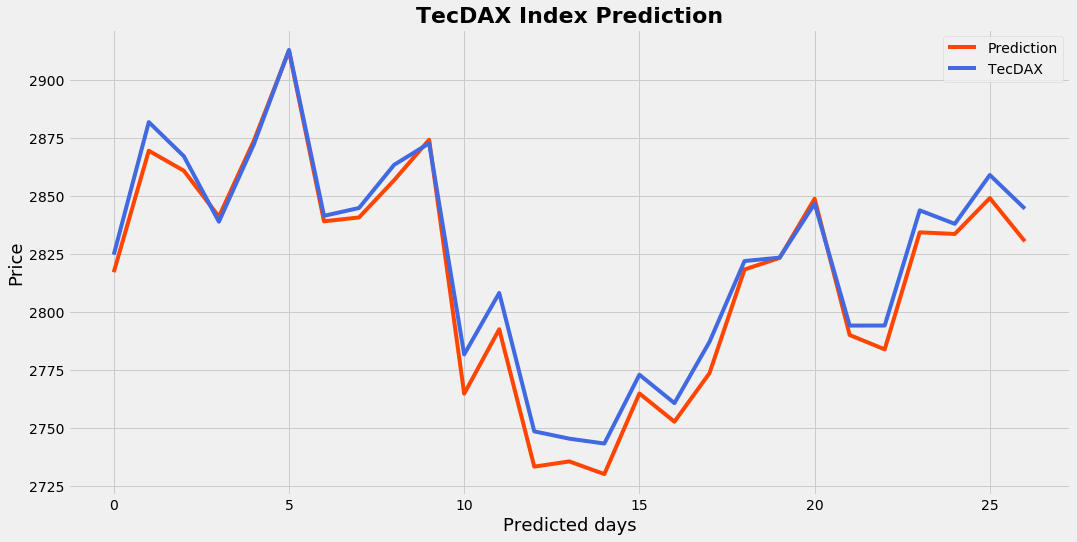

In [69]:
# plotting predicted Index prices against realised Index prices
predicted_level = model.predict(x_test)
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(predicted_level, color = 'orangered', label = 'Prediction')
plt.plot(y_test[0:,], color = 'royalblue', label = 'TecDAX')
plt.title('TecDAX Index Prediction', fontweight='bold',fontsize=22)
plt.xlabel('Predicted days',fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()

plt.show()

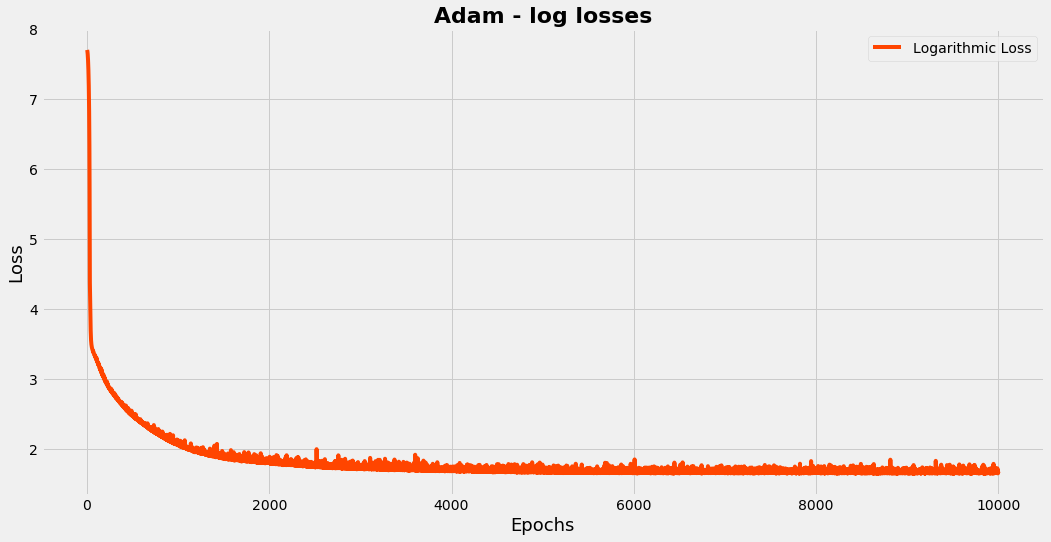

In [70]:
# visualising overfitting
history_dict = history.history
history_dict.keys()
loss_values = np.log(history_dict['val_loss'])
acc = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(epochs, loss_values, color = 'orangered', label = 'Logarithmic Loss')
plt.title('Adam - log losses', fontweight='bold',fontsize=22)
plt.xlabel('Epochs',fontsize=18,color='black')
plt.ylabel('Loss',fontsize=18,color='black')
plt.legend()

plt.show()

---
# 3. Additive Model Forecasting
---

In the scope of this report, forecasting is the attempt to predict how future prices will develop. We can distinguish between two major approaches in this matter, namely explanatory and time-series forcasting. While explanatory approaches aim to extract cause and effect relationships between input factors and output factors, time-series forecasting does not concentrate on understanding these relationships reather than finding patterns in past price realisations. There are two reasons for undertaking time-series forcasting. First, the system is too complex to be completely understood or the relationships that affect the output are to difficult to measure. Second, the main concern is not to understand why the output develops in a certain way but how it develops.

Not all forecasting problems can be solved by the same procedure. Prophet is optimized for business forecasting tasks, which have the following characteristics: hourly, daily, or weekly observations with at least a few months (preferably multiple years) of history. At its core, the Prophet procedure is an additive regression model with three main components:

 - A piecewise linear or logistic growth curve trend. Prophet automatically detects changes in trends by selecting changepoints from the data.
 - A yearly seasonal component modeled using Fourier series.
 - A weekly seasonal component using dummy variables.
 
We use the TecDAX Index dataset to train the Prophet Model. However we seperate the observations of the year 2018 and the first half of 2019 into a test set. After training the Prophet Model we predict 1,5 years of the Index Price and compare it to the realised observations in the test set. The prediction results will be shown as a solid blue line with an 80% confidence intervall(light blue area). In orange color we represent the true Index prices realised during the year 2018 and the first half of 2019.

One of the biggest upsides of the Prophet Model is that it does not only predict a possible realisation of a price at a certain time in the future, but also predicts the prices with a 80% confidence intervall. In the context of Stock or Index price realisations, confidence intervalls are an essential feature of forcasting models, since future price realisations are highly uncertain no matter how good the model is. 
 

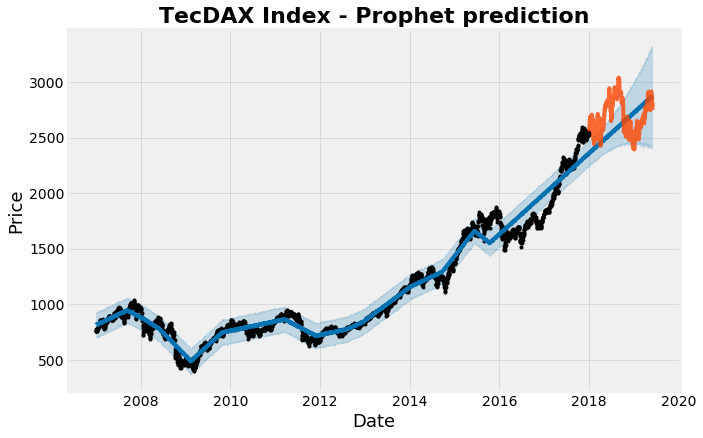

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,self_define_cycle,self_define_cycle_lower,self_define_cycle_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3297,2019-05-24,2866.524379,2408.871977,3306.247427,2428.651830,3295.735406,-1.943778,-1.943778,-1.943778,-1.943778,-1.943778,-1.943778,0.0,0.0,0.0,2864.580601
3298,2019-05-25,2867.520741,2414.732235,3282.500889,2428.443384,3298.317902,-2.194547,-2.194547,-2.194547,-2.194547,-2.194547,-2.194547,0.0,0.0,0.0,2865.326194
3299,2019-05-26,2868.517103,2404.005083,3282.731318,2429.986856,3300.900398,-3.054872,-3.054872,-3.054872,-3.054872,-3.054872,-3.054872,0.0,0.0,0.0,2865.462231
3300,2019-05-27,2869.513465,2408.125010,3314.111081,2430.137960,3303.482895,-3.828502,-3.828502,-3.828502,-3.828502,-3.828502,-3.828502,0.0,0.0,0.0,2865.684963
3301,2019-05-28,2870.509827,2398.107376,3317.664050,2430.253970,3306.049164,-1.224318,-1.224318,-1.224318,-1.224318,-1.224318,-1.224318,0.0,0.0,0.0,2869.285509


In [71]:
#  !! fitting the model can take significant amount of time and computation power !!

# setting up the model specifications
def cycle_analysis(data,split_date,cycle,mode='additive',forecast_plot = False,print_ind=False):
    
    # splitting the data in training and test set
    training = data[:split_date].iloc[:-1,]
    testing = data[split_date:]
    
    # defining the period to predict
    predict_period = len(pd.date_range(split_date,max(data.index)))
    df = training.reset_index()
    df.columns = ['ds','y']
    
    # exchanging default seasionality with self defined cycle
    model = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
    model.add_seasonality('self_define_cycle',period=cycle,fourier_order=8,mode=mode)
    
    # fitting the model
    model.fit(df)
    future = model.make_future_dataframe(periods=predict_period)
    forecast = model.predict(future)
   
    # visualising the results
    if forecast_plot:
        model.plot(forecast)
        plt.plot(testing.index,testing.values,color='orangered',alpha=0.8)
        plt.title("TecDAX Index - Prophet prediction",fontweight='bold',fontsize=22)
        plt.xlabel('Date',fontsize=18,color='black')
        plt.ylabel('Price',fontsize=18,color='black')
        plt.show()
    ret = max(forecast.self_define_cycle)-min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime("%Y-%m-%d"))
    
    #show model results (last 5 predictions)
    return forecast.tail()
      
# deploying the model to the TecDAX Index data
cycle_analysis(TecDAX_close,'2018-01-02',30,forecast_plot=True,print_ind=True)

---
# 4. Recurrent Neural Network Forecasting
---
Long Short-Term Memory Models (LSTM Models) are recurrent neural networks that are specifically designed to address the vanishing gradient problem. Neural networks weights change according to the partial derivation of the error function with resepect to the current weight in each iteration of training. Traditionally activation functions have gradients in the range of 0 to 1. With backpropagation computing gradients become too small when multiple layers are used. This can prevent training from working effectively.

We train the LSTM Model with the TecDAX Index price data from 01.01.2007 till 30.04.2019. We seperate the price data of May, 2019 in a test set to evaluate the predictions of the model.

In [72]:
# reshaping
TecDAX_close = TecDAX_close.values.reshape(len(TecDAX),1)

# spliting the data into training and test set
train_size = int(len(TecDAX_close) * 0.993)
test_size  = len(TecDAX_close) - train_size
TecDAX_train, TecDAX_test = TecDAX_close[0:train_size,:], TecDAX_close[train_size:len(TecDAX),:]

print("Training observations: ", len(TecDAX_train))
print("Testing observations:  ", len(TecDAX_test))

Training observations:  3120
Testing observations:   23


In [73]:
# normalizing the data
sc = MinMaxScaler(feature_range = (0, 1))

TecDAX_train.shape
training_set_scaled = sc.fit_transform(TecDAX_train)
test_set_scaled     = sc.fit_transform(TecDAX_test)

In [74]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

for i in range(60, 1258):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [75]:
# !! fitting the model can take significant amount of time and computation power !!

# initialising the RNN
regressor = Sequential()

# adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# adding the output layer
regressor.add(Dense(units = 1))

# compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0025
Epoch 2/100
1198/1198 [==============================] - 11s 9ms/step - loss: 5.3938e-04
Epoch 3/100
1198/1198 [==============================] - 10s 8ms/step - loss: 4.8937e-04
Epoch 4/100
1198/1198 [==============================] - 10s 8ms/step - loss: 4.5336e-04
Epoch 5/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.6816e-04
Epoch 6/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.8986e-04
Epoch 7/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.9768e-04
Epoch 8/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.6007e-04
Epoch 9/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.7167e-04
Epoch 10/100
1198/1198 [==============================] - 10s 8ms/step - loss: 3.0563e-04
Epoch 11/100
1198/1198 [==============================] - 10s 8ms/step - loss: 2.7297e-04
Epoch 12/100
1198/1198

In [76]:
# getting the predicted stock price
dataset_total = pd.concat((pd.Series(TecDAX_train[:,0]),
                           pd.Series(TecDAX_test[:,0])), axis = 0)
inputs = dataset_total[len(dataset_total) - len(TecDAX_test) - 60:]
inputs = inputs.values.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

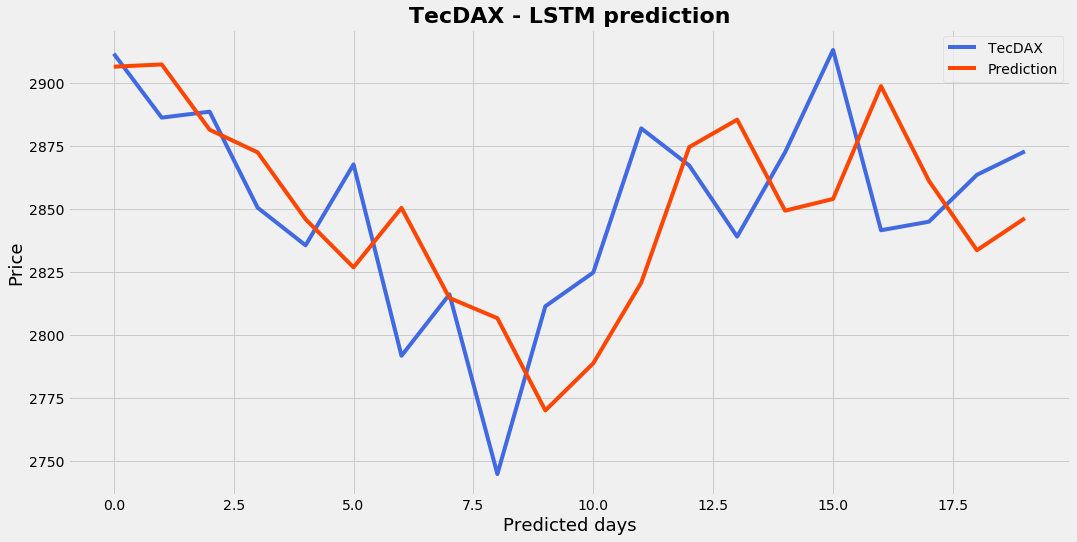

In [77]:
# Visualising the results
plt.rcParams["figure.figsize"] = (16,8)
plt.plot(TecDAX_test[0:20,:], color = 'royalblue', label = 'TecDAX')
plt.plot(predicted_stock_price, color = 'orangered', label = 'Prediction')
plt.title('TecDAX - LSTM prediction', fontweight='bold',fontsize=22)
plt.xlabel('Predicted days',fontsize=18,color='black')
plt.ylabel('Price',fontsize=18,color='black')
plt.legend()

plt.show()

---
**End of Report**. All datasets and code can be found in our GitHub repository:
https://github.com/innovationsteam/Index_Prediction